In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import torch
from torch import Tensor
import torch.nn.functional as F
from torch.optim.optimizer import Optimizer

from torch_scatter import scatter

from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.datasets import Planetoid
from torch_geometric.data import Data
import torch_geometric.transforms as T
from torch_geometric.nn import ChebConv, GCNConv  # noqa

from torch_geometric.data import InMemoryDataset, Data

---
### Data

In [4]:
edge = pd.read_csv('data/edge.csv', header=None)
node_feat_test = pd.read_csv('data/node_feat_test.csv')
node_feat_train = pd.read_csv('data/node_feat_train.csv')
node_feat_valid = pd.read_csv('data/node_feat_valid.csv')
node_label_train = pd.read_csv('data/node_label_train.csv')
node_label_valid = pd.read_csv('data/node_label_valid.csv')
node_year_test = pd.read_csv('data/node_year_test.csv')
node_year_train = pd.read_csv('data/node_year_train.csv')
node_year_valid = pd.read_csv('data/node_year_valid.csv')

---
### EDA

In [5]:
### Test Data label을 0으로 설정하여 계산을 편리하게 하기 위함. 

idx = pd.read_csv('data/node_year_test.csv', index_col=0)
idx['0'] = 0
idx.to_csv('data/node_label_test.csv')
node_label_test = pd.read_csv('data/node_label_test.csv')

In [6]:
### 아래 셀들은 gephi용 데이터를 내보내기 위한 과정들입니다. 

edge.columns=['source', 'target']

node_year = pd.concat([node_year_train,node_year_valid, node_year_test])
node_label = pd.concat([node_label_train,node_label_valid,node_label_test])
node_year.columns=['id', 'year']
node_label.columns =['id', 'label']

gephi_node = pd.merge(node_year, node_label, on='id')

In [7]:
label_1_nodelist = gephi_node[gephi_node.label== 1].id
label_1_node = gephi_node[gephi_node.label== 1]

label_1_and_edge = edge[edge.source.isin(label_1_nodelist) & edge.source.isin(label_1_nodelist)]
label_1_or_edge = edge[edge.source.isin(label_1_nodelist) | edge.source.isin(label_1_nodelist)]

label_1_and_edge.to_csv('label_1_and_edge.csv', index = False)
label_1_or_edge.to_csv('label_1_or_edge.csv', index = False)
label_1_node.to_csv('label_1_node.csv', index = False)

/Users/soobinchoi/anaconda3/envs/graph/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='Count'>

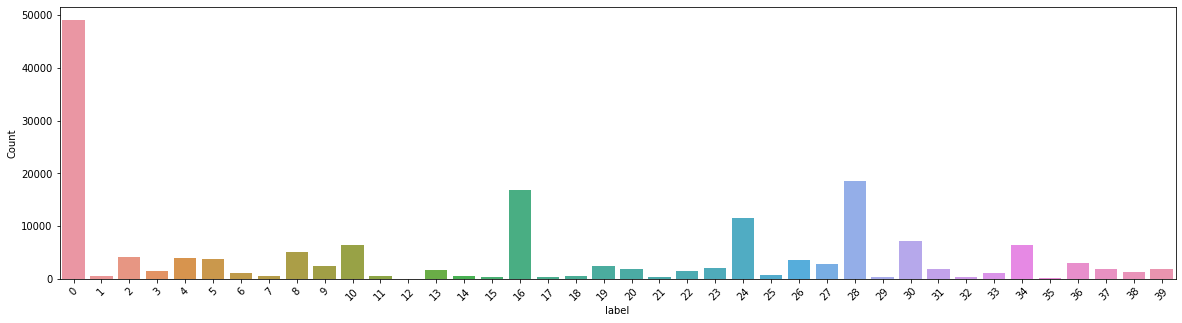

In [44]:
### label 분포 확인

plt.figure(figsize=(20,5))
plt.xticks(rotation=45)
plt.xlabel('Label', size = 10)
plt.ylabel('Count', size = 10)
sns.barplot(gephi_node.groupby('label').count().id.index, gephi_node.groupby('label').count().id.values)

<AxesSubplot:xlabel='label', ylabel='count'>

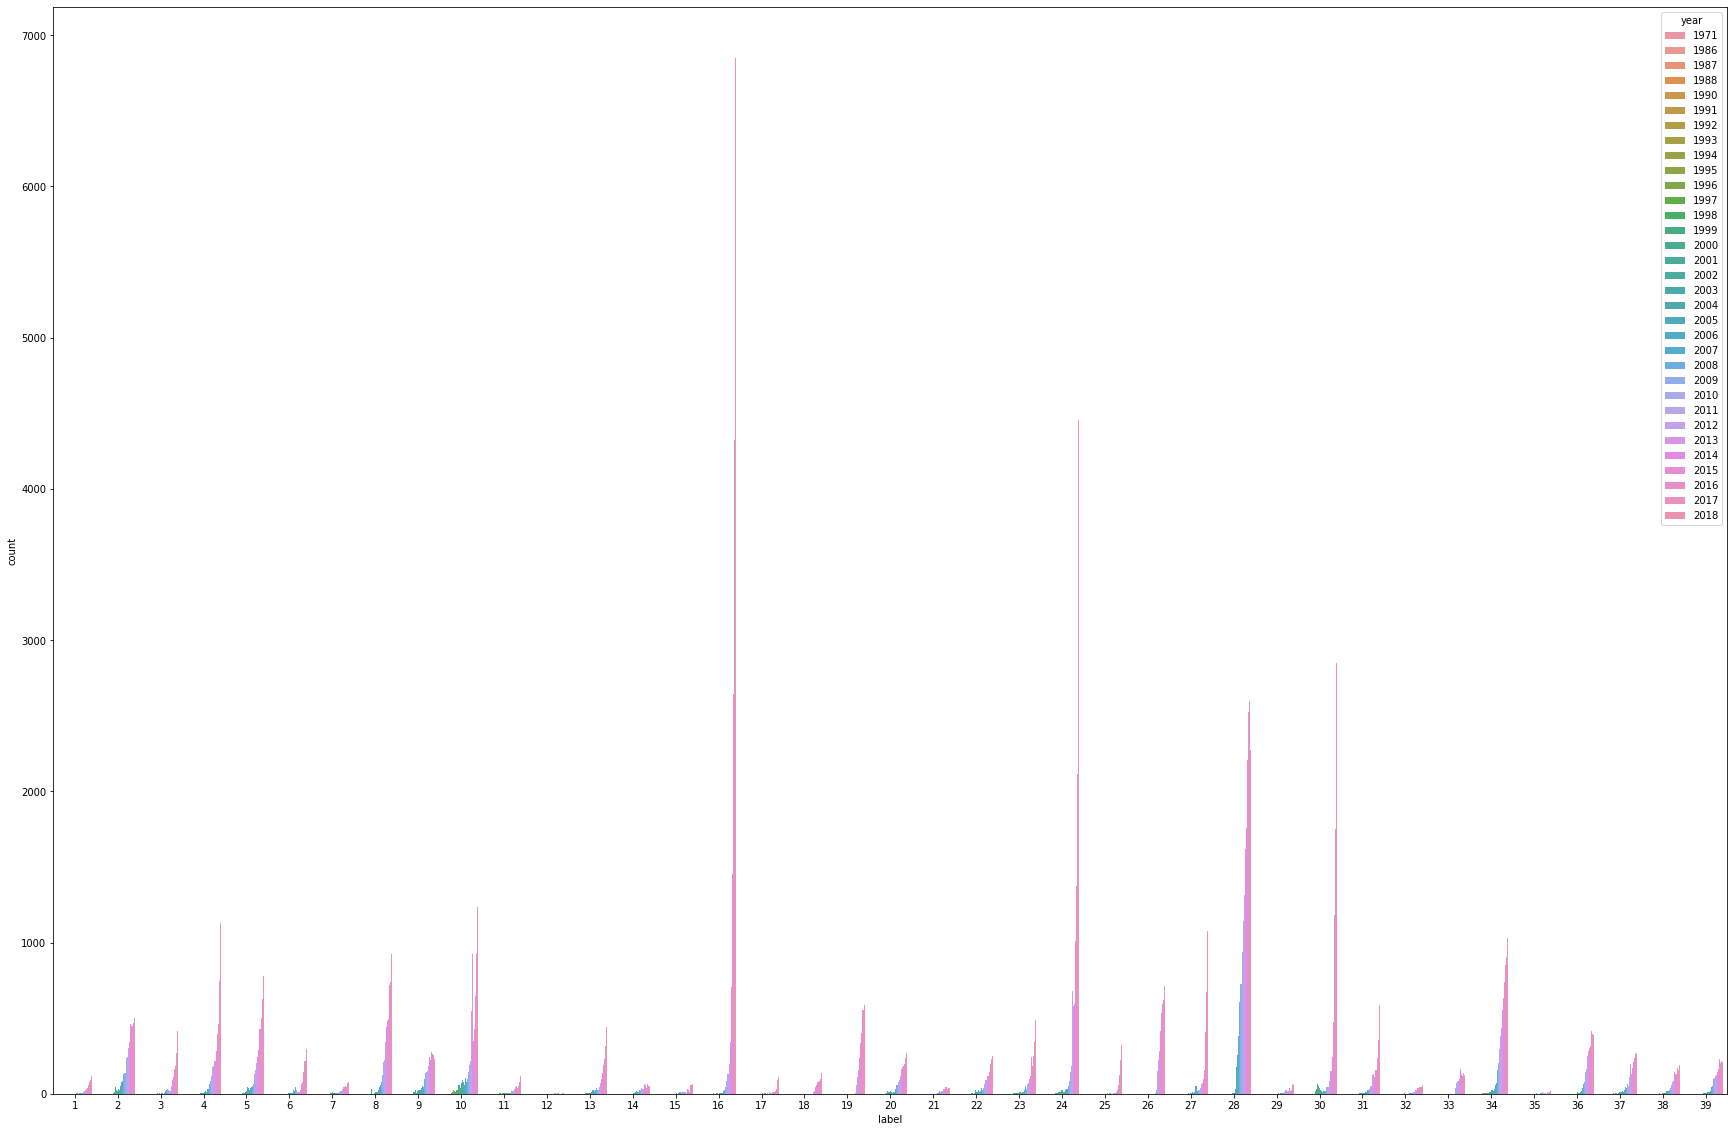

In [48]:
### year별, label별로 count 분포 확인

plt.figure(figsize=(30,20))
sns.countplot(x="label", hue="year", data=gephi_node[gephi_node.label != 0])

/Users/soobinchoi/anaconda3/envs/graph/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='year', ylabel='Count'>

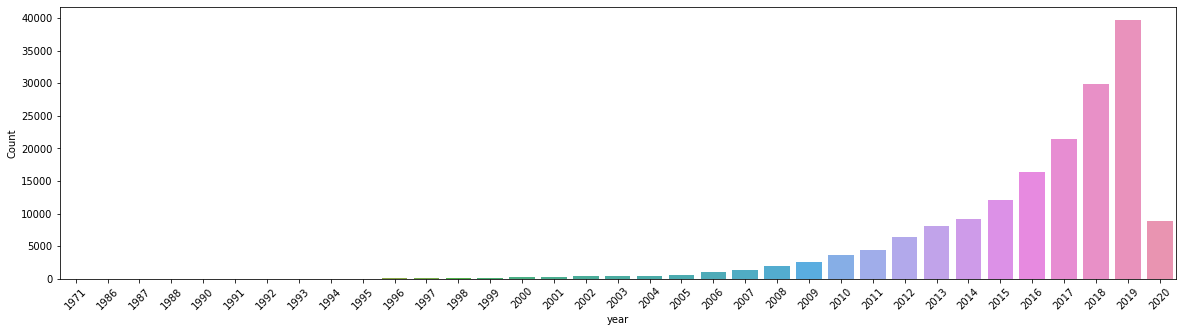

In [40]:
### 연도별 데이터 count

plt.figure(figsize=(20,5))
plt.xticks(rotation=45)
plt.xlabel('year', size = 10)
plt.ylabel('Count', size = 10)
sns.barplot(node_year.groupby('year').count().id.index, node_year.groupby('year').count().id.values)

In [8]:
### T-SNE

node_feat = pd.concat([node_feat_train,node_feat_valid,node_feat_test])

node_label_train.columns = ['id', 'label']
train_with_label = pd.merge(node_feat_train, node_label_train, on='id')

emb = TSNE(n_components=2, learning_rate='auto').fit_transform(node_feat.iloc[:, 1:-1])
labels = train_with_label['label'].values

C:\JupyterLab\resources\jlab_server\envs\graph\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


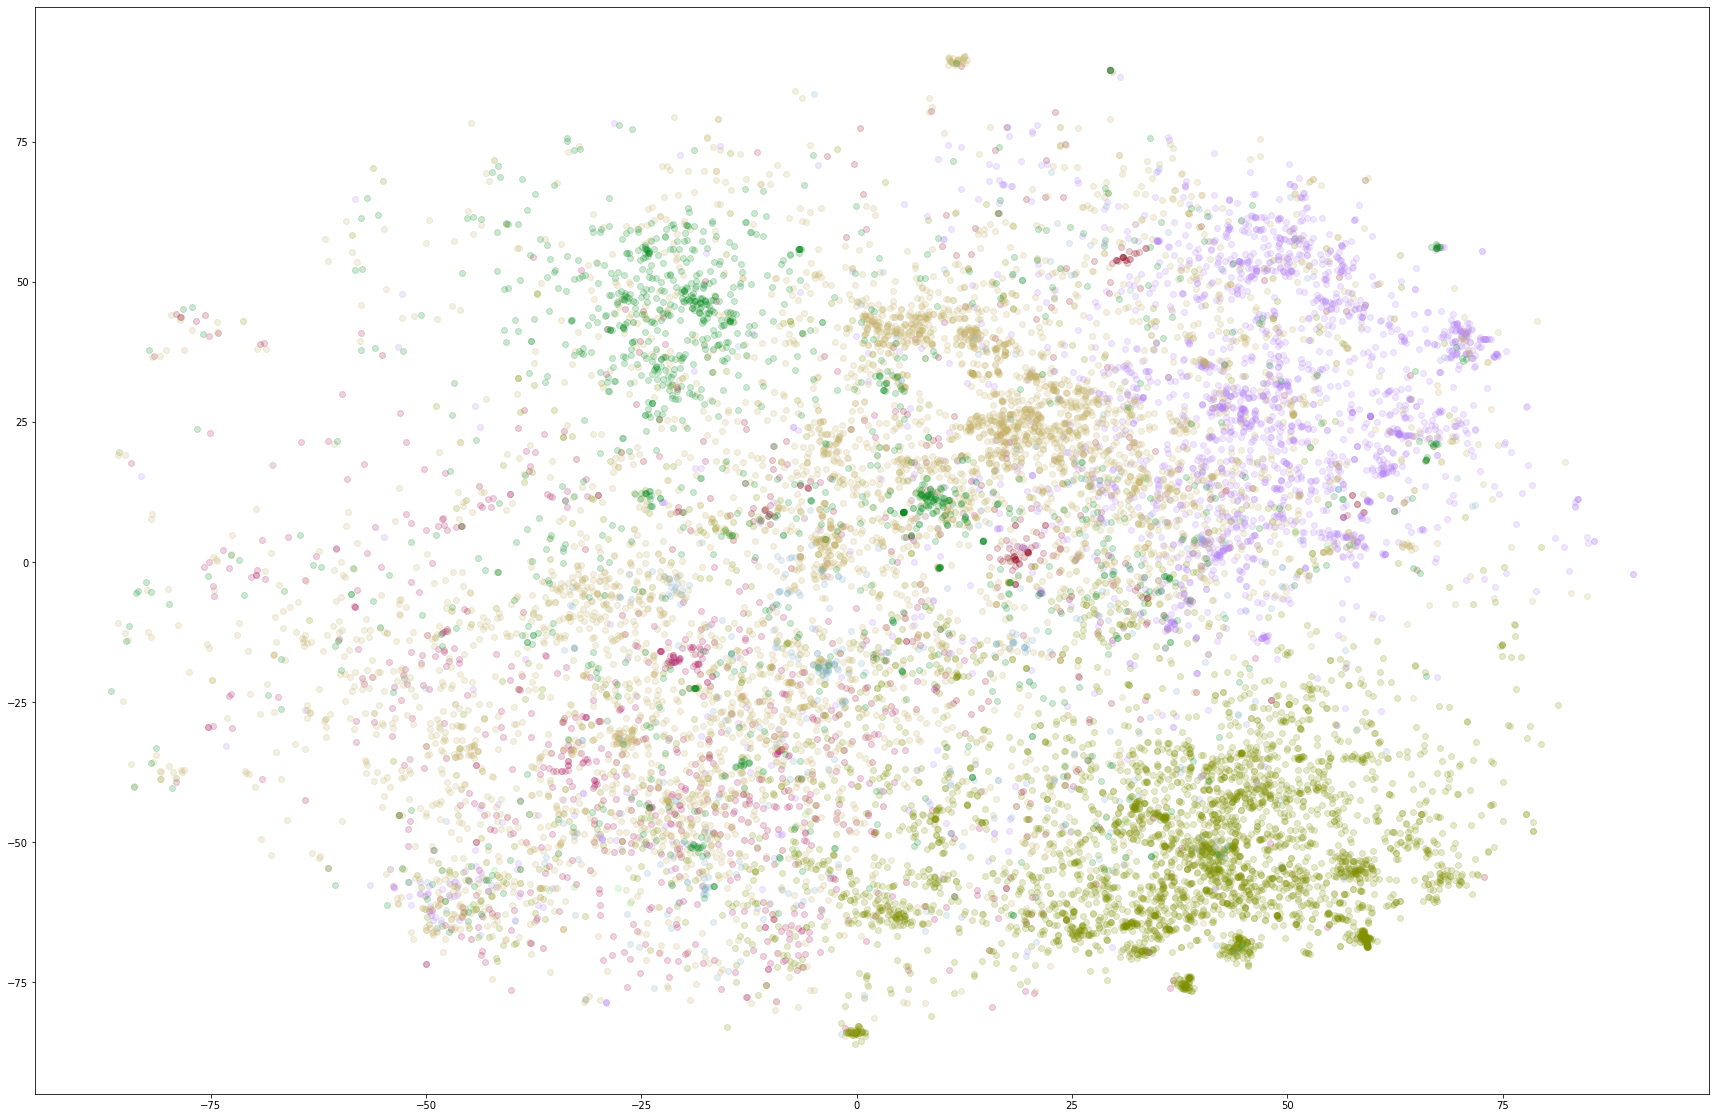

In [17]:
fig, ax = plt.subplots(figsize=(30,20))

number_of_colors = len(np.unique(labels))

color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]


for idx , i in enumerate(np.unique(labels)[6:14]) :
    emb_ = emb[np.where(labels == i ),:].squeeze()
    ax.scatter(x=emb_[:,0],y=emb_[:,1],c=color[idx], label=i,alpha=0.2)
plt.show()

---
### Modelling

In [4]:
### train, valid label 개수는 동일한가? 
len(node_label_train['0'].unique()), len(node_label_valid['0'].unique())

(40, 40)

In [4]:
node_x = pd.concat([node_feat_train, node_feat_valid, node_feat_test]) ## data.x
node_x = torch.tensor(node_x.drop('id', axis = 1).values, dtype=torch.float)
index_edge = torch.tensor(edge.values.T, dtype=torch.long) ## edge_index
edge_attr = None ## edge_attr

In [5]:
### test data에 해당하는 label은 100으로 대치. 

index_null = pd.DataFrame(index = range(len(node_x)),columns=['A'])
train_valid_label = pd.concat([node_label_train,node_label_valid])
train_valid_label.index = train_valid_label.id
tmp2 = train_valid_label.drop('id', axis = 1)

label = pd.concat([index_null, tmp2], axis = 1).drop('A', axis = 1)['0'].values
label[np.isnan(label)] = 100 
label = torch.tensor(label, dtype=torch.long)

num_features = len(node_feat_train.columns[1:])
num_classes = len(node_label_train['0'].unique())


PyTorch Geometric 에서 하나의 그래프는 torch_geometric.data.Data 라는 클래스로 표현됩니다.
특히, 이 클래스는 다음과 같은 default 속성이 있습니다.
이를 사용해 customdataset class를 정의하였습니다. 

> data.x : 노드 특징 행렬 [num_nodes, num_node_features]

> data.edge_index [2, num_edges]

> data.edge_attr : 엣지 특징 행렬 [num_edges, num_edge_features]

> data.y : 학습하고 싶은 대상 (타겟) / 그래프 레벨 → [num_nodes, *] /노드 레벨 → [1, *]

> data.pos : 노드 위치 행렬 [num_nodes, num_dimensions]

In [6]:
### custom dataset class 생성

class CustomDataset(InMemoryDataset):
    def __init__(self, transform=None):
        super(CustomDataset, self).__init__('.', transform, None, None)

        node_num = len(node_x)
        data = Data(edge_index=index_edge)
        data.num_nodes = len(node_x)
        
        data.x = node_x
        data.y = label.clone().detach()
        
        data.num_classes = len(node_label_train['0'].unique())
        n_nodes = len(node_x)
        
        # create train and test masks for data
        train_mask = torch.zeros(node_num, dtype=torch.bool)
        train_mask[node_year_train.id.unique()] = True

        valid_mask = torch.zeros(node_num, dtype=torch.bool)
        valid_mask[node_year_valid.id.unique()] = True

        test_mask = torch.zeros(node_num, dtype=torch.bool)
        test_mask[node_year_test.id.unique()] = True
                
        data['train_mask'] = train_mask
        data['test_mask'] = test_mask
        data['valid_mask'] = valid_mask

        self.data, self.slices = self.collate([data])

    def _download(self):
        return

    def _process(self):
        return

    def __repr__(self):
        return '{}()'.format(self.__class__.__name__)
    
dataset = CustomDataset()
data = dataset[0]

In [7]:
### GAT 모델 학습

class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.hid = 32
        self.in_head = 4
        self.out_head = 2
        
        
        self.conv1 = GATConv(data.num_features, self.hid, heads=self.in_head, dropout=0.2)
        self.conv2 = GATConv(self.hid*self.in_head, data.num_classes, concat=False,
                             heads=self.out_head, dropout=0.2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
                
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv2(x, edge_index)
        
        return F.log_softmax(x, dim=1)
    
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, data = GAT().to(device), dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Only perform weight-decay on first convolution.

def train():
    model.train()
    optimizer.zero_grad()
    F.nll_loss(model(data)[data.train_mask], data.y[data.train_mask]).backward()
    optimizer.step()


@torch.no_grad()
def test():
    model.eval()
    logits, accs = model(data), []
    
    mask =data.train_mask
    pred = logits[mask].max(1)[1]
    acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
    accs.append(acc)

    mask = data.valid_mask
    pred = logits[mask].max(1)[1]
    acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
    accs.append(acc)
    return accs


best_val_acc  = 0
for epoch in range(1, 50):
    train()
    print(epoch)
    train_acc, val_acc = test()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
      
    print(f'Epoch: {epoch:03d}, Train: {train_acc:.4f}, Best_Val: {best_val_acc:.4f}')

1
Epoch: 001, Train: 0.1789, Best_Val: 0.0763
2
Epoch: 002, Train: 0.1791, Best_Val: 0.0763
3
Epoch: 003, Train: 0.1788, Best_Val: 0.0764
4
Epoch: 004, Train: 0.1787, Best_Val: 0.0765
5
Epoch: 005, Train: 0.1790, Best_Val: 0.0765
6
Epoch: 006, Train: 0.1791, Best_Val: 0.0765
7
Epoch: 007, Train: 0.1791, Best_Val: 0.0765
8
Epoch: 008, Train: 0.1791, Best_Val: 0.0765
9
Epoch: 009, Train: 0.1791, Best_Val: 0.0765
10
Epoch: 010, Train: 0.1789, Best_Val: 0.0765
11
Epoch: 011, Train: 0.1791, Best_Val: 0.0765
12
Epoch: 012, Train: 0.1791, Best_Val: 0.0765
13
Epoch: 013, Train: 0.1791, Best_Val: 0.0765
14
Epoch: 014, Train: 0.1791, Best_Val: 0.0765
15
Epoch: 015, Train: 0.1791, Best_Val: 0.0765
16
Epoch: 016, Train: 0.1791, Best_Val: 0.0765
17
Epoch: 017, Train: 0.1791, Best_Val: 0.0765
18
Epoch: 018, Train: 0.1791, Best_Val: 0.0765
19
Epoch: 019, Train: 0.1791, Best_Val: 0.0765
20
Epoch: 020, Train: 0.1791, Best_Val: 0.0765
21
Epoch: 021, Train: 0.1791, Best_Val: 0.0765
22
Epoch: 022, Train: 

In [8]:
### GCN 모델 학습

class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(num_features, 64, cached=True)
                            # normalize=not args.use_gdc)
        self.conv2 = GCNConv(64, num_classes, cached=True)
                            #  normalize=not args.use_gdc)
        # self.conv1 = ChebConv(data.num_features, 16, K=2)
        # self.conv2 = ChebConv(16, data.num_features, K=2)

    def forward(self):
        x, edge_index, edge_weight = data.x, data.edge_index, edge_attr
        x = F.relu(self.conv1(x, edge_index, edge_weight))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)
        return F.log_softmax(x, dim=1)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, data = Net().to(device), data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Only perform weight-decay on first convolution.

def train():
    model.train()
    optimizer.zero_grad()
    F.nll_loss(model()[data.train_mask], data.y[data.train_mask]).backward()
    optimizer.step()


@torch.no_grad()
def test():
    model.eval()
    logits, accs = model(), []
    
    mask =data.train_mask
    pred = logits[mask].max(1)[1]
    acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
    accs.append(acc)

    mask = data.valid_mask
    pred = logits[mask].max(1)[1]
    acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
    accs.append(acc)

    return accs


best_val_acc  = 0
for epoch in range(1, 201):
    train()
    print(epoch)
    train_acc, val_acc = test()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
      
    print(f'Epoch: {epoch:03d}, Train: {train_acc:.4f}, Best_Val: {best_val_acc:.4f}')

1
Epoch: 001, Train: 0.0618, Best_Val: 0.0739
2
Epoch: 002, Train: 0.1626, Best_Val: 0.1028
3
Epoch: 003, Train: 0.1770, Best_Val: 0.1028
4
Epoch: 004, Train: 0.1434, Best_Val: 0.1717
5
Epoch: 005, Train: 0.1144, Best_Val: 0.2044
6
Epoch: 006, Train: 0.0826, Best_Val: 0.2044
7
Epoch: 007, Train: 0.1149, Best_Val: 0.2044
8
Epoch: 008, Train: 0.1433, Best_Val: 0.2044
9
Epoch: 009, Train: 0.1641, Best_Val: 0.2044
10
Epoch: 010, Train: 0.1715, Best_Val: 0.2044
11
Epoch: 011, Train: 0.1695, Best_Val: 0.2044
12
Epoch: 012, Train: 0.1691, Best_Val: 0.2044
13
Epoch: 013, Train: 0.1630, Best_Val: 0.2044
14
Epoch: 014, Train: 0.1697, Best_Val: 0.2044
15
Epoch: 015, Train: 0.1751, Best_Val: 0.2044
16
Epoch: 016, Train: 0.1748, Best_Val: 0.2044
17
Epoch: 017, Train: 0.1754, Best_Val: 0.2044
18
Epoch: 018, Train: 0.1766, Best_Val: 0.2044
19
Epoch: 019, Train: 0.1830, Best_Val: 0.2044
20
Epoch: 020, Train: 0.1818, Best_Val: 0.2044
21
Epoch: 021, Train: 0.1852, Best_Val: 0.2044
22
Epoch: 022, Train: 